# Scam Prediction in Reddit

Done by : Zineb Bouharra, Rémi Hurstel, Ivo Bonetti, Ihssane Ghalas, Chaimaa Akharaze, Maroua El-Arni

### Problem Statement 

Online scams are a persistent problem on social media platforms, and Reddit is no exception. Scammers often use manipulative tactics to deceive unsuspecting users into participating in fraudulent schemes, which can result in significant financial loss and other negative consequences. Detecting these scams is a challenging task, as scammers use subtle language and psychological techniques to evade detection. Moreover, the vast and diverse nature of Reddit's user-generated content makes it difficult to identify and analyze all potential scam posts and comments manually. As a result, there is a pressing need for an effective scam prediction model for Reddit that can accurately detect and alert users to potential scams.


To address this problem, researchers and developers have been exploring various approaches to predict scams on Reddit. Some of the proposed techniques include using machine learning algorithms, natural language processing, and network analysis to identify patterns and anomalies in Reddit's user-generated content. These approaches aim to develop models that can automatically distinguish between legitimate and fraudulent posts and comments. By leveraging the vast amounts of data available on Reddit, these models can learn to detect subtle cues and characteristics that indicate scam-like behavior.


Therefore, the challenge is to develop an effective scam prediction model for Reddit that can accurately identify and alert users to potential scam posts and comments, ultimately reducing the risk of financial harm and improving the overall safety and trustworthiness of the platform.

### Necessary imports

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import re
import pickle

from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()
stop_words = stopwords.words('english')

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ivobo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivobo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ivobo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ivobo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

First, we need to download the dataset.

In [3]:
!python download_data.py

The original data contains 147843 examples that we split into train and test datasets as follows :

- The training dataset contains 67% of the original dataset. It is accessible in CSV format in data/train.csv

- The testing dataset contains 33% of the original dataset. It is accessible in CSV format in data/test.csv

we load the data using the utility function designed for the challenge in `problem.py`.

In [4]:
from problem import get_train_data, get_test_data
data_train = get_train_data()
data_test = get_test_data()

### Data Insights

In [5]:
data_train.head()

,name,comment_karma,link_karma,type,body,subreddit,label
0,vegiraghav,15790,21569,comment,That's gotta be the ball of the match.,Cricket,0
1,theoutlet,174587,21576,comment,I’m one of those assholes with no taste that p...,AskReddit,0
2,NedvedTom,1528,891,comment,"jade spear, 2pc pale flame, 2pc bloodstained, ...",YunjinMains,0
3,dash_x,6247,1785,comment,Three Amigos,AskReddit,1
4,TheOldNorth-apricity,327,4,comment,The Entmoot has begun,WritingPrompts,0


Karma features are reference of the popularity of a post. The higher a karma feature is, the more popular the post is.

In [6]:
data_train.shape

(118274, 7)

In [7]:
data_test.head()

,name,comment_karma,link_karma,type,body,subreddit,label
0,slamy420,15882,2558,comment,"Native species, no issue",snails,0
1,SourcerySprinkles,554,568,comment,My therapist is encouraging me to make an acco...,mutualapp,0
2,chronicheartache,4743,5963,submission,Can I consider myself butch even though I’m ag...,actuallesbians,0
3,MarshallsNuts,3698,872,submission,géo healer : Going for a 4 geo team and my hea...,IttoMains,0
4,applesinfrance,136,234,comment,"Must read: The 13 Clocks by James Thurber, The...",booksuggestions,0


In [8]:
data_test.shape

(29569, 7)

In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118274 entries, 0 to 118273
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           118274 non-null  object
 1   comment_karma  118274 non-null  int64 
 2   link_karma     118274 non-null  int64 
 3   type           118274 non-null  object
 4   body           118273 non-null  object
 5   subreddit      118274 non-null  object
 6   label          118274 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 6.3+ MB


In [10]:
data_train.describe()

,comment_karma,link_karma,label
count,1.182740e+05,1.182740e+05,118274.00000
mean,1.072808e+04,7.060894e+03,0.30338
std,5.366773e+04,7.705072e+04,0.45972
min,-1.000000e+02,1.000000e+00,0.00000
25%,3.562500e+02,1.020000e+02,0.00000
50%,1.985000e+03,8.910000e+02,0.00000
75%,8.167000e+03,4.411000e+03,1.00000
max,3.141592e+06,4.841046e+06,1.00000


In [11]:
data_train.describe(include=object)

,name,type,body,subreddit
count,118274,118274,118273,118274
unique,9122,2,114596,15884
top,picklelope_a,comment,u/savevideo,AskReddit
freq,20,66789,111,3172


As we can see, our dataset contains basically two types of data, some columns are integers while the others are objects.

In the following part, we will do some data exploration to have a better understanding of it.

### Data Exploration

First, we check if there are any missing values in the dataset

In [12]:
data_train.isna().sum()

name             0
comment_karma    0
link_karma       0
type             0
body             1
subreddit        0
label            0
dtype: int64

In [13]:
data_test.isna().sum()

name             0
comment_karma    0
link_karma       0
type             0
body             0
subreddit        0
label            0
dtype: int64

Due to the very small amount of missing values in the dataset compared to the amount of data provided, dropping the line containnig the missing value will not have much effect on the quality of our data and then, of the prediction. 

In [14]:
data_train = data_train.dropna(axis=0)

comment       66788
submission    51485
Name: type, dtype: int64


<AxesSubplot:>

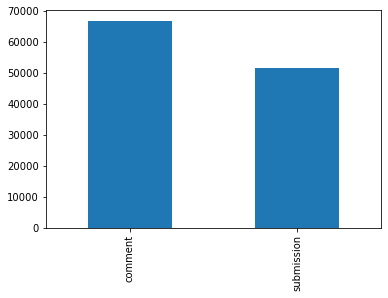

In [15]:
print(data_train.type.value_counts())
data_train.type.value_counts().plot(kind='bar')

And then we plot the count of each label (0,1).

0    82392
1    35881
Name: label, dtype: int64


<AxesSubplot:>

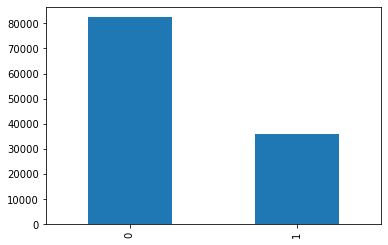

In [16]:
print(data_train.label.value_counts())
data_train.label.value_counts().plot(kind='bar')

Let's plot the distribution of the variable type when it comes to our target.

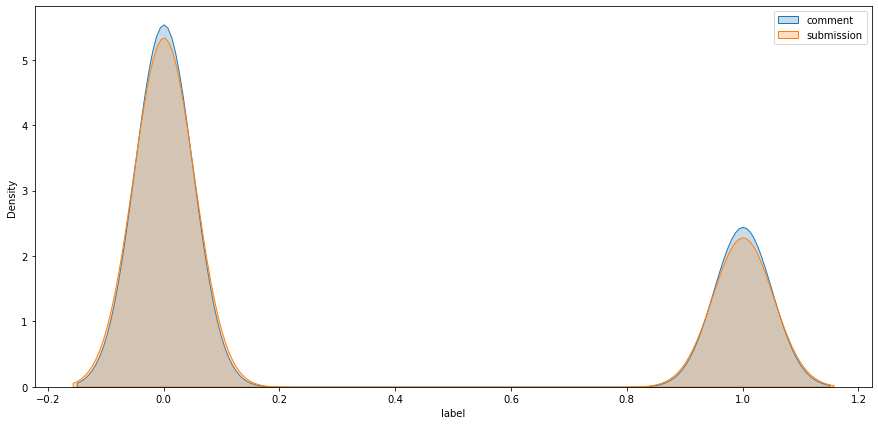

In [17]:
vals = list(data_train['type'].unique())
plt.figure(figsize=(15,7))
for val in vals:
    sns.kdeplot(data_train[data_train['type']==val]['label'],label=val,shade=True)
plt.legend()

Let's now plot the correlation between the numerical features

<AxesSubplot:>

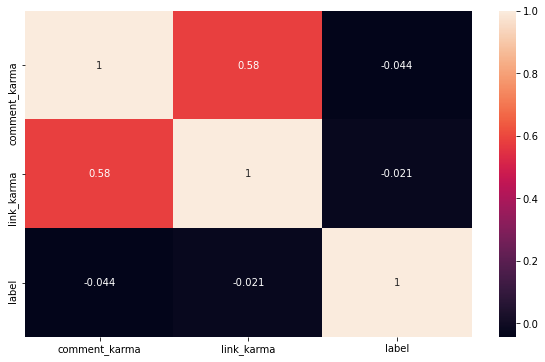

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(data_train.corr(method='pearson'),annot=True)

We can plot a pair plot. This will show us how numerical feature's points are distributed in relation to other features.

[]

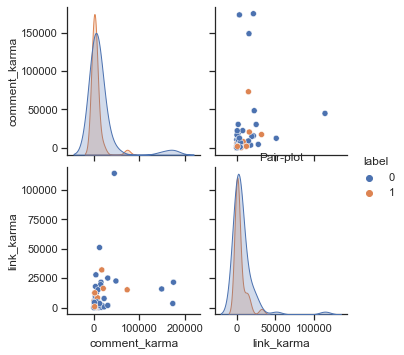

In [19]:

sns.set_theme(style='ticks')
sns.pairplot(data_train.iloc[:100], hue='label')
plt.title('Pair-plot')
plt.plot()

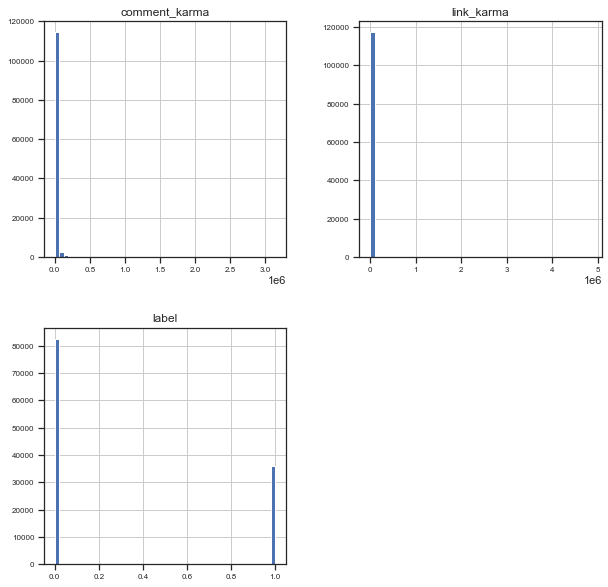

In [20]:
data_train.hist(figsize=(10, 10), bins = 50, xlabelsize=8, ylabelsize=8)
plt.show()

### Pre processing

In [21]:
y_train = data_train['label']
y_test = data_test['label']

del data_train['label']
del data_test['label']

In [22]:
import re
def remove_emoji(string):
    "function to remove emojis"
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

remove_emoji("Hilarious 😂! ")

'Hilarious ! '

In [23]:
def preprocessing(x):
     """preprocessing the text"""
     corp = str(x).lower()  #lower
     corp = re.sub('[^a-zA-Z]+',' ', corp).strip() #keep text
     #corp = re.sub('[0-9]+', '', corp)
     corp=remove_emoji(corp) # remove emojis
     tokens = word_tokenize(corp) #tokenization
     words = [w for w in tokens if len(w) > 2 if not w in stop_words] # remove stop words and words with less than two caracters
     lemmatize = [lemma.lemmatize(w) for w in words] #lemmatization
     l=(' ').join(lemmatize)
     return l
 
def preprocess(X):
    preprocess_text = [preprocessing(i) for i in X['body']]
    X["preprocessed_body"] = preprocess_text
    return X

In [24]:
### preprocessing train/test
X_train = preprocess(data_train)
X_test = preprocess(data_test)
X_test=X_test.reset_index()
X_train=X_train.reset_index()

Here is a glimpse of how our new training data looks after the pre processing step.

In [25]:
X_train.head()

,index,name,comment_karma,link_karma,type,body,subreddit,preprocessed_body
0,0,vegiraghav,15790,21569,comment,That's gotta be the ball of the match.,Cricket,got ball match
1,1,theoutlet,174587,21576,comment,I’m one of those assholes with no taste that p...,AskReddit,one asshole taste prefers plan
2,2,NedvedTom,1528,891,comment,"jade spear, 2pc pale flame, 2pc bloodstained, ...",YunjinMains,jade spear pale flame bloodstained atk phys dm...
3,3,dash_x,6247,1785,comment,Three Amigos,AskReddit,three amigo
4,4,TheOldNorth-apricity,327,4,comment,The Entmoot has begun,WritingPrompts,entmoot begun


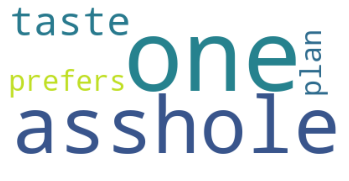

In [26]:
##Scammer 
#pip install wordcloud
text=X_train["preprocessed_body"][1]
wordcloud = WordCloud(background_color = 'white',  max_words = 50).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

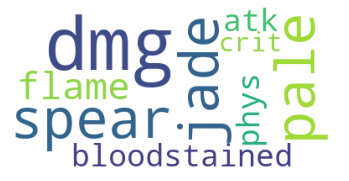

In [27]:
## non Scammer 
text=X_train["preprocessed_body"][2]
wordcloud = WordCloud(background_color = 'white',  max_words = 50).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Baseline model

In [28]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder

class get_estimator(BaseEstimator):
    
    def __init__(self):
       
        self.text = ['preprocessed_body']
        self.numerical = ['link_karma','comment_karma']
        self.categorical = ['type',  'subreddit']
        
        self.model = Pipeline([
        ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
        ('tfid', TfidfTransformer()),
        ('clf',  LogisticRegression()),
        ])

        
    def fit(self, X, y):
        X=preprocess(X)
        self.model.fit(X['preprocessed_body'],y)
        return self
 
    def predict(self, X):
        X=preprocess(X)
        pred= self.model.predict(X['preprocessed_body'])
        return pred
    
    def predict_proba(self, X):
        X=preprocess(X)
        pred= self.model.predict_proba(X['preprocessed_body'])
        return pred

In [29]:
model=get_estimator()

In [30]:
model.fit(data_train,y_train)

get_estimator()

### Evaluation

In [31]:
val_pred = model.predict(data_test)
val_pred_proba = model.predict_proba(data_test)

In [32]:
from collections import Counter
print("-------- Predictions information --------")
print(val_pred_proba.shape,'\n')
print("Prediction values count:",Counter(val_pred),"\n")
print("True values count:",y_test.value_counts())

-------- Predictions information --------
(29569, 2) 

Prediction values count: Counter({0: 25090, 1: 4479}) 

True values count: 0    20525
1     9044
Name: label, dtype: int64


In [33]:
print(classification_report(y_test, val_pred))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85     20525
           1       0.72      0.36      0.48      9044

    accuracy                           0.76     29569
   macro avg       0.75      0.65      0.66     29569
weighted avg       0.76      0.76      0.73     29569



Text(0.5, 1.0, 'Confusion matrix of predictions on scams')

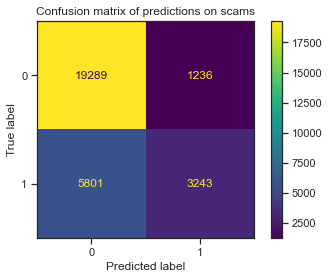

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plot = ConfusionMatrixDisplay.from_predictions(y_test,val_pred)
plt.title("Confusion matrix of predictions on scams")

In [35]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, val_pred))

0.7620142717034732


In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, val_pred)

0.6491805146957814

### Submission Details

Your RAMP submission should be in the folder "submissions" (e.g "submissions/estimator.py").

The code we gave is a baseline that is made of a pre processing step and a prediction step. You can be creative and search for ways to improve the score !